In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.auto import tqdm, trange
import pickle as pkl
from time import sleep
import os
import pickle as pkl


In [2]:
%load_ext autoreload
%autoreload 2

from hex_show import *
from hex_pathfinding import *
from hex_helpers import *
from hex_train_helpers import *
from hex_minmax import *
from hex_mcts import *



ckpt_fname = 'temp/net_checkpoint.dat'
worker_fname = 'temp/net_worker.dat'
selfplay_fnmask = 'temp/selfplay_%d.dat'


## Initialisierung

In [3]:

class RandomPlayer(MiniMax):
    @staticmethod
    def findmove(board):
        while True:
            k = np.random.randint(N**2)
            if board[divmod(k,N)]==0:
                return divmod(k,N)
            
            
def ClassicAI(depth):
    if depth==0:
        return RandomPlayer()
    return MiniMax(maxdepth=depth)

## Pitting

In [4]:
# Funktion für das pitten zweier ai`s (Wettkampf mit n Runden)

def pit(ai1, ai2, n=20, nrnd=0, verbose=0):
    '''Pits two ai for n rounds. First nrnd moves are randomly chosen.
    confidence: sigma interval in where you want to know one ai is better than the other
    '''
        
    if type(n) is type(None) or n==np.Inf:
        n = int(1e10)
    
    wins1 = 0
    wins2 = 0
    
    for k in range(n):

        if k%2 == 0:
            ai_red  = ai1
            ai_blue = ai2
        else:
            ai_red  = ai2
            ai_blue = ai1
            
        if k%2 == 0:
            board0 = filledboard(bsize, nrnd, FRAME)
            
        board = board0.copy()
        turn = (-1)**(board!=0).sum()

        while True:

            if turn>0:
                #'Reds turn'

                # Move by an AI
                #x, y = ai_red.findmove(board, True, verbose=0)
                x, y = ai_red.findmove(board)

            else:
                #'Blues turn'

                # Move by an AI
                #x, y = ai_blue.findmove(board, False, verbose=0)
                x, y = ai_blue.findmove(board)


            board[x,y] = turn
            turn *= -1
            
            if verbose>=2:
                show_board(board)


            # If someone has won
            won = winner(board)
            if won!=0:
                break

        if k%2==1:
            won *= -1
        wins1 += int(+won/2+1/2)
        wins2 += int(-won/2+1/2)
        sigma = np.sqrt(wins1*wins2/(wins1+wins2))
        
        try: ai1.clear()
        except: pass
        try: ai2.clear()
        except: pass
        
        if verbose:
            print(wins1, k+1)
        
        
    #return wins1, wins2
    return wins1/n

## Training

In [26]:

# Batch generator for neural network training

def batchgen(gamerecords, size=50, istart=0, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            x1s = np.zeros((size, 5, N, N)) # board
            x2s = np.zeros((size, 1, N, N)) # valid
            y1s = np.zeros((size, 1, N, N)) # policy
            y2s = np.zeros((size, 1))       # value
            for i, k in enumerate(mb):
                try:
                    x1, x2, y1, y2 = gamerecords[k]
                except:
                    x, y1, y2 = gamerecords[k] # x is in board format -> preprocess and save in right way
                    x1, x2 = net.preprocess(x)
                    gamerecords[k] = x1, x2, y1, y2
                x1s[i] = x1
                x2s[i,0] = x2
                ii, jj = y1
                y1s[i, 0, ii, jj] = 1
                y2s[i] = y2
            yield x1s, x2s, y1s, y2s
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
        
        
def ensemble(nets, *args):
    num = len(nets)
    for i in range(num):
        with torch.no_grad():
            p, v = nets[i](*args)
            
        if i == 0:
            ps, vs = p/num, v/num
        else:
            ps += p/num
            vs += v/num
    return ps, vs
        

def train(net, gamerecords, gamerecords_legacy, iterations=4000, teachers=[], aug_ds=True, cons_ds=False, verbose=0):
    '''Trainiert das Netz
    aug_ds: Augmentation durch Drehspiegelung (Flip in x und y)
    cons_ds: Konsistenzbedingung unter Drehspiegelung auf dem unsupervised Set
    teacher_function: Eine Funktion, nach der auf dem unsupervised Set das Netzwerk trainiert wird. Wenn None wird der MTeacher genutzt'''

    #if net is None:
    #    net = Net(n=64)
    optimizer = torch.optim.Adam(lr=3e-4, params=net.parameters(), weight_decay=1e-4)
    bg_s = batchgen(gamerecords, size=200)                 #### istart erhöhen um valbatch zu haben? für early stopping?
    bg_u = batchgen(gamerecords_legacy, size=150)
    BCE = nn.BCELoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(-yt*torch.log(yp+1e-4))
    losses = []
    semlosses = []
    mtlosses = []
    semloss = 0

    # Trainings loop
    vloss_min = np.Inf
    for k in trange(iterations):

        # ==== Supervised step ====
        b, vd, tp, tv = next(bg_s)
        b, vd, tp, tv = batch2torch(b, vd, tp, tv)
        
        if aug_ds:
            if np.random.rand()<0.5:
                b = torch.flip(b, [2, 3])
                vd = torch.flip(vd, [2, 3])
                tp = torch.flip(tp, [2, 3])
            
        pp, pv = net(b, vd)
        
        
        # For softmax LogLoss, for sigmoid BCE
        _loss = LogLoss(pp.reshape(-1), tp.reshape(-1)) + MSE(pv, tv)
        loss = _loss.item() # torch to float
        if teachers:
            epp, epv = ensemble(teachers, b, vd) ###
            semloss = 2*(MSE(pp, epp) + MSE(pv, epv) + L1Loss(pv, epv))###
            _loss += semloss
            semloss = semloss.item()
        _loss.backward()

        '''
        # ==== Unsupervised step ====
        if cons_ds:
            b1, vd1, _, _ = batch2torch(*next(bg_u))

            # Drehspiegelung als augmentation
            b2  = torch.flip(b1,  [2, 3])
            vd2 = torch.flip(vd1, [2, 3])

            # --> welches Netzwerk ?
            pp1, pv1 = net(b1, vd1)
            pp2, pv2 = net(b2, vd2)
                
            if cons_ds:
                pp2 = torch.flip(pp2, [2, 3]) ## flip back
            semloss  = MSE(pp1.reshape(-1), pp2.reshape(-1)) + MSE(pv1, pv2)
            
            semloss *= 2
            semloss.backward()
            semloss = semloss.item()
        else:
            semloss = 0
        '''
        

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()

        
        # Statistic
        losses += [loss]
        semlosses += [semloss]
        
        # Verbose output, measure minimum val loss
        if len(losses) == 100:
            if verbose>=1:
                print('Loss=%f, SSLoss=%f'% (np.mean(losses), np.mean(semlosses)))
            losses = []
            
    return net

In [12]:

with open('gamrec13x13_MMaxD1_2000.dat', 'rb') as f:
    game_rec = pkl.load(f)

Loss=0.073067, SSLoss=0.000000, std(v)=0.189407


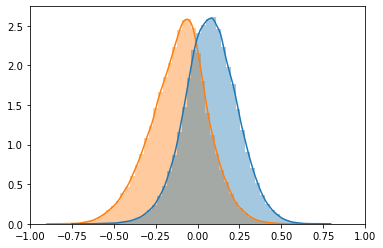

Loss=0.054314, SSLoss=0.000000, std(v)=0.235367


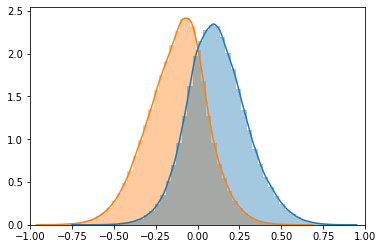

Loss=0.046782, SSLoss=0.000000, std(v)=0.282158


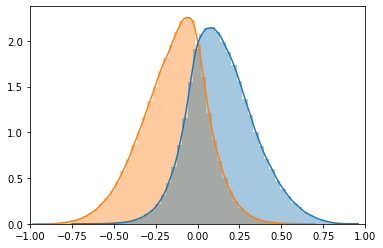

Loss=0.040402, SSLoss=0.000000, std(v)=0.330841


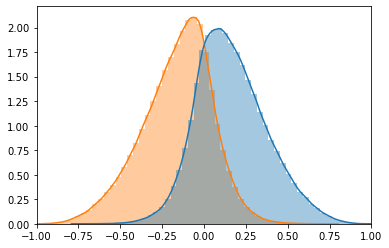

Loss=0.036123, SSLoss=0.000000, std(v)=0.363650


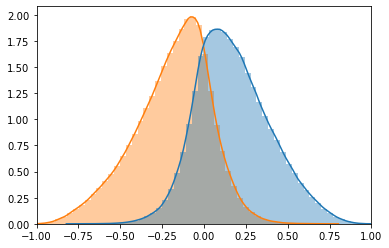

Loss=0.033675, SSLoss=0.000000, std(v)=0.387719


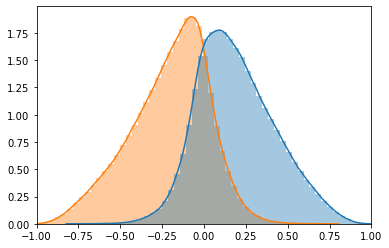

Loss=0.031498, SSLoss=0.000000, std(v)=0.394122


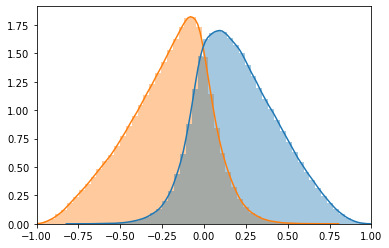

Loss=0.028371, SSLoss=0.000000, std(v)=0.443740


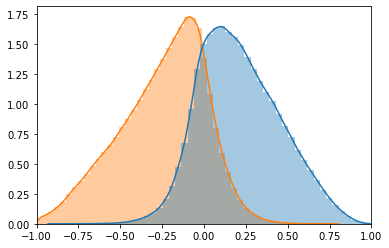

Loss=0.029411, SSLoss=0.000000, std(v)=0.446598


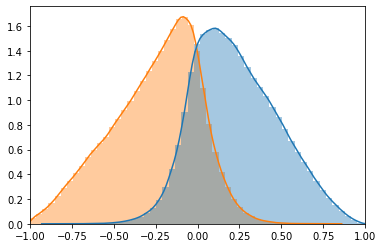

Loss=0.029029, SSLoss=0.000000, std(v)=0.476716


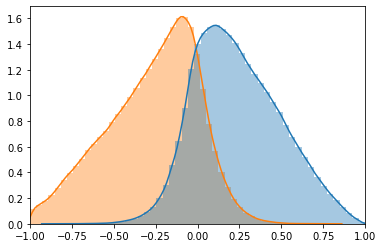

Loss=0.027903, SSLoss=0.000000, std(v)=0.461952


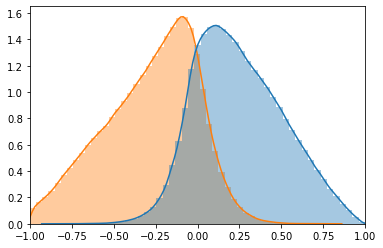

Loss=0.026214, SSLoss=0.000000, std(v)=0.481853


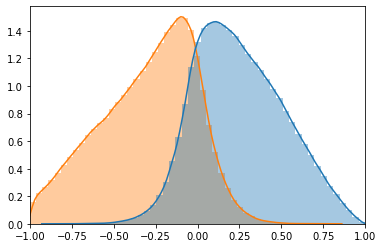

Loss=0.025894, SSLoss=0.000000, std(v)=0.477442


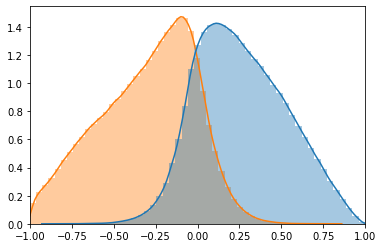

Loss=0.024958, SSLoss=0.000000, std(v)=0.482950


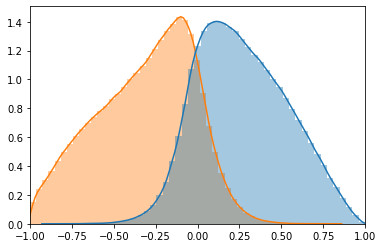

Loss=0.024509, SSLoss=0.000000, std(v)=0.523170


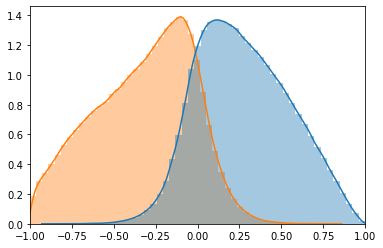

Loss=0.024899, SSLoss=0.000000, std(v)=0.523011


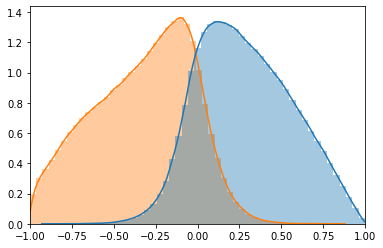

Loss=0.024461, SSLoss=0.000000, std(v)=0.508795


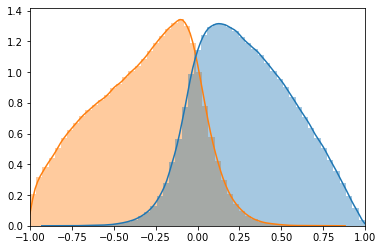

Loss=0.023978, SSLoss=0.000000, std(v)=0.526527


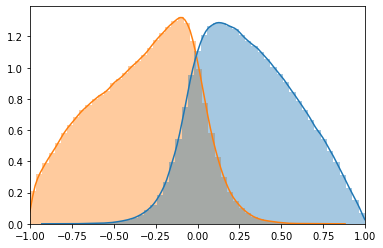

Loss=0.024089, SSLoss=0.000000, std(v)=0.526064


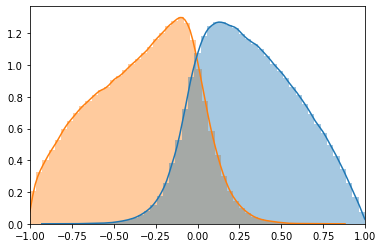

Loss=0.023446, SSLoss=0.000000, std(v)=0.523146


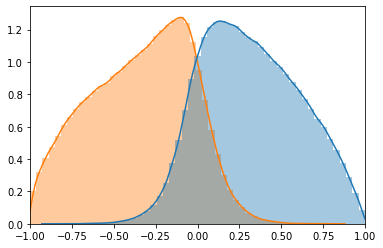

Loss=0.023365, SSLoss=0.000000, std(v)=0.523914


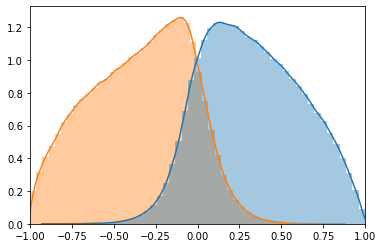

Loss=0.023632, SSLoss=0.000000, std(v)=0.527547


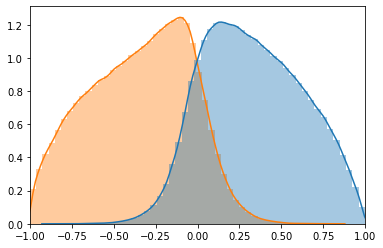

Loss=0.022379, SSLoss=0.000000, std(v)=0.523898


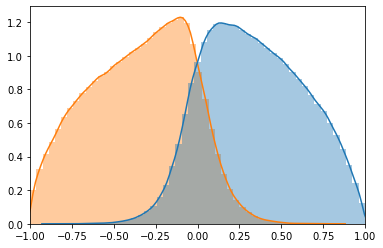

Loss=0.023102, SSLoss=0.000000, std(v)=0.535649


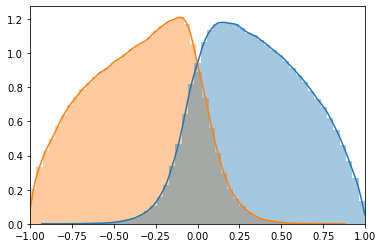

Loss=0.022870, SSLoss=0.000000, std(v)=0.515136


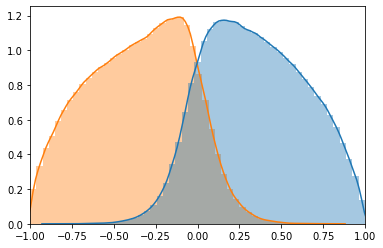

KeyboardInterrupt: 

In [27]:
####
mean_teacher=None
N=13
from hex_net13x13 import Net13x13
from experimental_train import *
net = Net13x13()
train(net, game_rec, [0], iterations=20000, mt_tau=0.99, verbose=1)
####

# DER WINNER_LOSS VERGLEICHT ZWEI BOARDS, EINS VERLIERT UND EINS GEWINNT.
# BEIDE 

### Selfplay

In [16]:

bsize = 13



def selfplay(ai, ngames=1000, verbose=0):
    
    red_wins = 0
    blue_wins = 0
    games_record = []

    # Iterator with tqdm??
    iter = range(ngames)
    if verbose>=1:
        iter = tqdm(iter)
        
    # Play n games!
    for k in iter:

        ai.eta = 0.3

        records = []
        
        #board = np.zeros((bsize,bsize), int)
        board = filledboard(bsize, 3)
        turn = getturn(board)

        while True:

            x, y = ai.findmove(board)
            validmask = (board==0)
            
            if turn > 0:
                records += [(board.copy(), (x,y), validmask, turn)]
            else:
                records += [(-board.T.copy(), (y,x), validmask.T, turn)]
                

            board[x,y] = turn
            turn *= -1

            # If someone has won
            won = winner(board)
            if won!=0:
                #path = winning_path(board)
                if verbose >= 2:
                    if won==+1:
                        print('Red has won!')
                    else:
                        print('Blue has won!')
                if verbose >= 3:
                    show_board(board)
                    show_path(path)
                    plt.show()
                break

        red_wins  += int(+won/2+1/2)
        blue_wins += int(-won/2+1/2)

        winpath = winning_path(board)

        # Spiele aufzeichnen

        games_record += [ (b, m, d, t*won) for b, m, d, t in records ]
        
    return games_record

In [17]:


def newboard():
    part = np.random.rand()
    while True:
        board = filledboard(bsize, part)
        if not winner(board):
            return board
        part *= .99 # avoid infinite loop

            
def selfplay_batched(ai, ngames=1000, verbose=0):
    
    bnum = ai.nparallel
    game_records = []
    
    ai.eta = 0.3

    # Iterator with tqdm??
    if verbose>=1:
        pbar = tqdm(total=ngames)
        
    
    boards = [ newboard() for _ in range(bnum) ]
    turns = [ getturn(brd) for brd in boards ]
    records = [ [] for _ in range(bnum) ]
    
    
    completedgames = 0
    while completedgames < ngames:
        
        moves = ai.findmove(boards)
        for b in range(bnum):
            turn = turns[b]
            x, y = moves[b]
            valid = (boards[b]==0)
            records[b] += [(boards[b].copy(), (x, y), valid, turn)] if turn > 0 else \
                          [(-boards[b].T.copy(), (y, x), valid.T, turn)]
            boards[b][x, y] = turns[b]
            turns[b] *= -1
            
            won = winner(boards[b])
            if won:
                game_records += [ (b, m, d, t*won) for (b, m, d, t) in records[b] ]
                completedgames += 1
                records[b] = []
                boards[b] = newboard()
                turns[b] = getturn(boards[b])
                if verbose>=1:
                    pbar.update(1)
    
    if verbose>=1:
        pbar.close()
        
    return game_records

## Netzwerkdefinition

In [20]:
N=13

from hex_net13x13 import *

In [18]:

net = Net13x13()
mean_teacher = None


# ## net.load_state_dict(torch.load(model_fname))
# ##net.load_state_dict(torch.load(ckpt_fname))

torch.save(net.state_dict(), ckpt_fname)
torch.save(net.state_dict(), worker_fname)

with open('gamrec13x13_MMaxD1_2000.dat', 'rb') as f:
    game_rec = pkl.load(f)
#game_rec = selfplay(RandomPlayer(), ngames=600, verbose=1)
game_rec_leg = selfplay(RandomPlayer(), ngames=1200, verbose=1)
print(f'Game record / legacy has length {len(game_rec)} / {len(game_rec_leg)}')
winrates = []
mmdepths = []
depthminimax = 0
stage = 0



Game record / legacy has length 75519 / 178780


In [ ]:

mean_teacher = None
net = Net13x13()
stage = 0

while True:

    
    # Train
    if stage==0:
        print('Training')
        train(net, game_rec, game_rec_leg, iterations=2000, mt_tau=0.99, verbose=1)
        torch.save(net.state_dict(), f'F:/$Daten/Modelcp/hex13x13/net13x13_{time()%1000000}.dat')
        stage = 1
    
    
    # Evaluate/Pit
    if stage==1:
        print('Pitting')
        
        winrate = pit(MultiMCTS(nparallel=5, nsearches=50, net=mean_teacher, params={'useQ':True, 'newCP':1, 'cuncert':4}), ai_reference(depthminimax), n=20, nrnd=1/2, verbose=0)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        plt.plot(winrates, 'C2')
        plt.plot(np.array(mmdepths)/10, 'C0o-', lw=0.5)
        plt.show()
        if winrate>0.7 and depthminimax<2:
            depthminimax += 1
            print(f'Changing minimax depth to {depthminimax}')
            
        winrate = pit(MultiMCTS(nparallel=5, nsearches=50, net=net, params={'useQ':True, 'newCP':1, 'cuncert':4}),
                      MultiMCTS(nparallel=5, nsearches=50, net=Net13x13(path=ckpt_fname), params={'useQ':True, 'newCP':1, 'cuncert':4}), n=10, nrnd=1/2, verbose=0)
        print(f'Winrate against last checkpoint is {winrate}')
        #winrate = pit(MultiMCTS(nparallel=5, nsearches=50, net=net, params={'useQ':True, 'newCP':1, 'cuncert':4}),
        #              MultiMCTS(nparallel=5, nsearches=50, net=mean_teacher, params={'useQ':True, 'newCP':1, 'cuncert':4}), n=20, nrnd=1/2, verbose=0)
        #print('WINRATE OF NET AGAINST MEAN TEACHER:', winrate)
        stage = 2
        
    
    # Exchange Network
    if stage==2:
        print(f'Exchanging worker network')
        torch.save(net.state_dict(), ckpt_fname)
        torch.save(mean_teacher.state_dict(), worker_fname)
        stage=3
        
        
    if stage==3:
        print('Load Selfplay')
        newgames = load_selfplay(numacquire=2000) #4000 wenn alle worker extern, hier verringert da dieser mitworkt
        game_rec = newgames + game_rec
        replay_size = 1000000
        replay_size_leg = 5000000
        tolegacy = max(round(len(newgames)*0.5), len(game_rec)-replay_size)
        game_rec, game_rec_leg = game_rec[:-tolegacy], game_rec[-tolegacy:] + game_rec_leg
        game_rec_leg = game_rec_leg[:replay_size_leg]
        print('number of new states:', len(newgames))
        print('size of game rec / game rec legacy):', len(game_rec), len(game_rec_leg))
        stage=0
    

In [ ]:
%timeit -n 100 net.predictStack(np.ones((1,13,13)), np.ones((1,13,13)))

In [ ]:
torch.save(net.state_dict(), 'net_selfplay150.dat')

In [ ]:
pickle.dump(game_rec, open('netselfplay_gamerecords150sims.pkl', 'wb'))

In [ ]:
field = [ np.random.choice([0, 1, 2]) for _ in range(5) ]
# field2num
num = 0
field2 = field.copy()
while field2:
    x = field2.pop()
    num = 3*num + x
    
#num = sum([ field[i] * 3**i for i in range(len(field))])
# num2field
field2 = []
num2 = num
while num2 != 0:
    num2, x = divmod(num2, 3)
    field2.append(x)

field, num, field2


In [ ]:
divmod(13**2, 5)

In [ ]:
from numba import jit, njit
from numba.typed import List

@njit
def five3tobyte(triplers, l=5):
    n = 0
    for i in range(l):
        n *= 3
        n += triplers[i]
    return n

@njit
def byte2five3(n):
    l = []
    for i in range(5):
        n, x = divmod(n, 3)
        l.append(x)
    return l[::-1]

def board13x13_2_bytes(board):
    brd = board.reshape(169) + 1
    bytes = np.empty(14, dtype='uint8')
    for i in range(14):
        tripler = brd[5*i:5*(i+1)]
        bytes[i] = five3tobyte(tripler, len(tripler))
    return bytes

def bytes_2_board13x13(bytes):
    brd = 


triplers = List([ np.random.choice([0, 1, 2]) for _ in range(5) ])
#triplers = [ 2 for _ in range(5) ]
byte = five3tobyte(triplers)
retriplers = byte2five3(byte)
triplers, byte, retriplers